In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from scipy.stats import norm, bernoulli
import json
import warnings; warnings.simplefilter('ignore')
from tqdm.auto import tqdm
from plot_utils import make_width_coverage_plot, get_data, transform_features, make_length_table, make_coverage_table, make_error_table
from baselines import classical_ols_ci
from ppi import ppi_ols_ci
from reppi import ppi_opt_ols_ci_crossfit

In [2]:
np.random.seed(1)

In [3]:
data = pd.read_csv('../text_data/US_wine.csv')
data = data.sample(frac=1).reset_index(drop=True) # shuffle data
# data = data.dropna()
Yhat = data["gpt_point"].to_numpy()
Yhat[Yhat<80] = 80
Y = data["points"].to_numpy()
n = len(Y)



In [4]:
data['is_ca'] = (data['province'] == 'California').astype('int64')
data['is_wa'] = (data['province'] == 'Washington').astype('int64')
data['is_or'] = (data['province'] == 'Oregon').astype('int64')
data['is_ny'] = (data['province'] == 'New York').astype('int64')

In [5]:
X = np.column_stack((np.log(data['price']), data['is_ca'], data['is_wa'], data['is_or'], data['is_ny'], np.ones(n))).astype(float)

In [6]:
data['province'].value_counts()

California           6616
Washington           1643
Oregon                967
New York              495
Virginia              137
Idaho                  29
America                23
Michigan               14
Texas                  14
Colorado               13
New Mexico             11
Arizona                 9
Pennsylvania            6
North Carolina          6
Ohio                    4
Missouri                4
Massachusetts           2
New Jersey              2
Iowa                    1
Kentucky                1
Illinois                1
Nevada                  1
Washington-Oregon       1
Name: province, dtype: int64

In [7]:
print(data)

      Unnamed: 0 country                                        description  \
0          89115      US  A pretty good Syrah, although there's somethin...   
1          13704      US  This 100% Cabernet is tannic, acidic and dry, ...   
2          20157      US  This is the finest of the winery's three new r...   
3          40889      US  Aromas of fresh asparagus, grass and tropical ...   
4         100184      US  From the excellent Evergreen vineyard comes a ...   
...          ...     ...                                                ...   
9995       90937      US  From Northridge Vineyard grapes, this mix of f...   
9996       42668      US  Barrel notes of spice, vanilla, caramel and he...   
9997       59972      US  Acidity is the main thing you notice when you ...   
9998      104924      US  High alcohol gives this wine some heat, and al...   
9999       11759      US  Rustic and a little sweet tasting, this has fl...   

                                designation  points

In [8]:
print(np.linalg.inv(X.T@X/5479))

[[  1.72561249  -0.58360443  -0.337665    -0.58145064   0.18170103
   -5.42707703]
 [ -0.58360443  20.66351252  19.75219158  19.83464021  19.5765413
  -17.80254818]
 [ -0.337665    19.75219158  23.03882006  19.75177013  19.60243787
  -18.57603135]
 [ -0.58145064  19.83464021  19.75177013  25.49989173  19.57676809
  -17.80932191]
 [  0.18170103  19.5765413   19.60243787  19.57676809  30.72581219
  -20.2094453 ]
 [ -5.42707703 -17.80254818 -18.57603135 -17.80932191 -20.2094453
   36.70623109]]


In [9]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)
result = model.fit(X, Y)
target_index = 0
theta_true = result.coef_[target_index]


In [10]:
num_trials = 50
alpha = 0.1
labeled_fracs = np.linspace(0.10,0.30,30)
n_all = Y.shape[0]

In [11]:
results = []
columns = ["lb", "ub", "interval width", "coverage", "estimator", "n", "mse"]
temp_df = pd.DataFrame(np.zeros((4,len(columns))), columns=columns)
error = np.zeros(4)

for j in tqdm(range(len(labeled_fracs))):
    n = int(labeled_fracs[j]*n_all)
    
    for i in tqdm(range(num_trials)):   
        labeled = np.random.choice(range(n_all), n, replace=False)
        unlabeled = list(set(range(n_all)) - set(labeled))
        X_lab = X[labeled]
        Y_lab = Y[labeled]
        Yhat_lab = Yhat[labeled]
        X_unlab = X[unlabeled]
        Yhat_unlab = Yhat[unlabeled]
        
        
        l, u = classical_ols_ci(X_lab, Y_lab, alpha=alpha)
        coverage = int((theta_true >= l[target_index])*(theta_true <= u[target_index]))
        mse = np.abs(l[target_index]+u[target_index]-2*theta_true)/2
        temp_df.loc[0] = l[target_index], u[target_index], (u[target_index] - l[target_index]), coverage, "XY-only", n, mse
        error[0] += mse

        l, u = ppi_ols_ci(X_lab, Y_lab, Yhat_lab, X_unlab, Yhat_unlab, alpha=alpha, lhat=1)
        coverage = int((theta_true >= l[target_index])*(theta_true <= u[target_index]))
        mse = np.abs(l[target_index]+u[target_index]-2*theta_true)/2
        temp_df.loc[1] = l[target_index], u[target_index], (u[target_index] - l[target_index]), coverage, "PPI", n, mse
        error[1] += mse

        l, u = ppi_ols_ci(X_lab, Y_lab, Yhat_lab, X_unlab, Yhat_unlab, alpha=alpha)
        coverage = int((theta_true >= l[target_index])*(theta_true <= u[target_index]))
        mse = np.abs(l[target_index]+u[target_index]-2*theta_true)/2
        temp_df.loc[2] = l[target_index], u[target_index], (u[target_index] - l[target_index]), coverage, "PPI++", n, mse
        error[2] += mse
        
        l, u = ppi_opt_ols_ci_crossfit(X_lab, Y_lab, Yhat_lab, X_unlab, Yhat_unlab, alpha=alpha, method='linreg')
        coverage = int((theta_true >= l[target_index])*(theta_true <= u[target_index]))
        mse = np.abs(l[target_index]+u[target_index]-2*theta_true)/2
        temp_df.loc[3] = l[target_index], u[target_index], (u[target_index] - l[target_index]), coverage, "RePPI", n, mse
        error[3] += mse

        results += [temp_df.copy()]
df = pd.concat(results,ignore_index=True)

100%|██████████| 30/30 [02:21<00:00,  4.73s/it]


In [12]:
df['labeled ratio'] = round(df['n'] / n_all, 2)

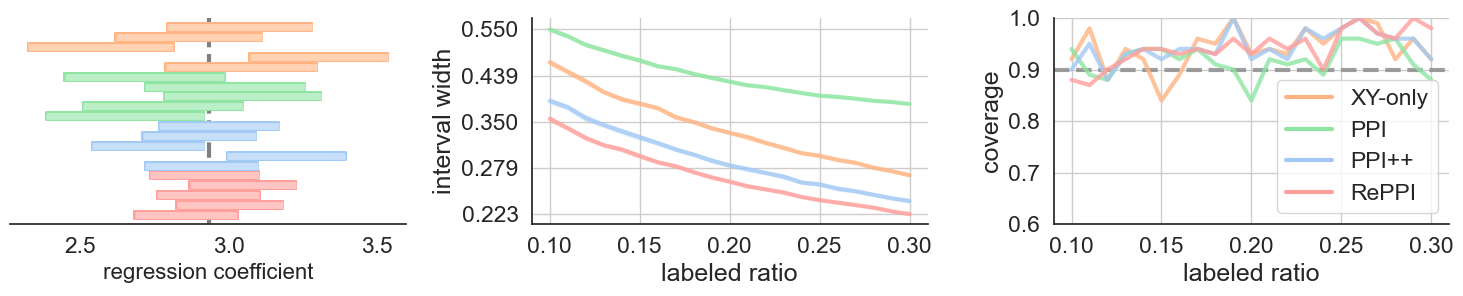

In [13]:
make_width_coverage_plot(df, "regression coefficient", "../results/wine.pdf", theta_true, num_trials = num_trials, n_example_ind = 0)

In [14]:
df_width = make_length_table(df)
print(df_width)

     XY-only       PPI     PPI++     RePPI       n
0   0.468679  0.550420  0.387860  0.355283  1000.0
1   0.456600  0.539611  0.383763  0.346061  1068.0
2   0.438072  0.525455  0.368407  0.332512  1137.0
3   0.426903  0.510332  0.356384  0.323511  1206.0
4   0.409223  0.503371  0.346315  0.314578  1275.0
5   0.400881  0.490876  0.343031  0.309929  1344.0
6   0.391191  0.484101  0.334277  0.305765  1413.0
7   0.382636  0.472898  0.324766  0.296085  1482.0
8   0.378885  0.465231  0.318551  0.291011  1551.0
9   0.370108  0.454613  0.312375  0.283479  1620.0
10  0.358114  0.453268  0.305845  0.281667  1689.0
11  0.356433  0.445151  0.301643  0.276687  1758.0
12  0.343122  0.440192  0.294623  0.270519  1827.0
13  0.339298  0.434350  0.289490  0.266736  1896.0
14  0.334830  0.431090  0.285594  0.263725  1965.0
15  0.328843  0.421330  0.280111  0.258739  2034.0
16  0.324731  0.418726  0.277587  0.255357  2103.0
17  0.318157  0.416469  0.274248  0.252228  2172.0
18  0.313454  0.413663  0.27094

In [15]:
n_value = [0.27, 0.28, 0.29, 0.30, 0.31, 0.32]
interpolated_values = {}
for method in ["XY-only", "PPI", "PPI++", "RePPI"]:
    interpolated_values[method] = np.interp(n_value, df_width[method][::-1], df_width['n'][::-1])
print(interpolated_values)

{'XY-only': array([2992.77693917, 2787.46602089, 2610.5934654 , 2417.6263467 ,
       2287.35019527, 2152.65867939]), 'PPI': array([3000., 3000., 3000., 3000., 3000., 3000.]), 'PPI++': array([2260.85621581, 2037.02464117, 1889.13823323, 1774.14550259,
       1645.09435334, 1534.91413016]), 'RePPI': array([1836.46621796, 1712.09827605, 1560.25948563, 1454.09519482,
       1342.94304973, 1233.12005752])}
